# Setup and Imports

In [1]:
import os
import json
import numpy as np
import nibabel as nib # This library deals with medical images - nifty images
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import random
import time

# Dataset Class

### This class is a custom dataset loader for PyTorch that:
- Reads MRI brain scans (and tumor segmentations) from .nii.gz files (from the BraTS dataset),
- Applies preprocessing like cropping, normalizing, and flipping,
- Converts the 3D MRI data into tensors (PyTorch’s format) so they can be used to train a neural network (U-Net in your case).

In [2]:
class BraTSDataset(Dataset):
    def __init__(self, data_path, crop_dim=(128, 128, 128), number_output_classes=3, randomize=False):
        """
            data_path: Folder where your dataset lives.
        	crop_dim: Size of the 3D patch extracted from the full MRI scan (like zooming into a 128×128×128 box).
        	number_output_classes: How many types of tumor regions you want to segment.
        	randomize: If True, applies random flipping/cropping (used to “augment” your dataset to make your model more robust).
        """
        self.data_path = data_path
        self.crop_dim = crop_dim
        self.randomize = randomize
        self.number_output_classes = number_output_classes
        self._load_metadata()

    def _load_metadata(self):
        """
        	This loads a dataset.json file which contains paths to all MRI and mask files.
        	It stores:
            	self.input_channels: e.g., FLAIR, T1, T2…
            	self.output_channels: e.g., edema, enhancing tumor, etc.
            	self.filenames: pairs of image and corresponding mask file paths.
        """
        with open(os.path.join(self.data_path, "dataset.json"), 'r') as f:
            metadata = json.load(f)

        self.input_channels = metadata["modality"]
        self.output_channels = metadata["labels"]
        self.filenames = [
            (os.path.join(self.data_path, entry["image"]), os.path.join(self.data_path, entry["label"]))
            for entry in metadata["training"]
        ]

    def __len__(self):
        """
        This allows PyTorch to know how many samples the dataset has.
        """
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        This method is called when PyTorch wants the idx-th MRI scan.
        """
        img_path, msk_path = self.filenames[idx]
        
        # img = np.array(nib.load(img_path).dataobj)[..., 0]  # Loads the FLAIR MRI scan (3D data) and selects the first channel.
        img = nib.load(img_path).get_fdata(dtype=np.float32)[..., 0]

        img = np.rot90(img) # Rotates it (to match visual orientation).
        img = img[..., np.newaxis]  # adds a “channel” dimension. -> (D, H, W, 1)

        # Loads the tumor mask (label data).
        # msk = np.array(nib.load(msk_path).dataobj)
        msk = nib.load(msk_path).get_fdata(dtype=np.float32)

        msk = np.rot90(msk)
    
        if self.number_output_classes == 1:
            msk = (msk > 0).astype(np.float32)[..., None]  # shape: (D, H, W, 1)
        else:
            # Converts a single tumor map into multiple binary channels:
        	# Channel 0: everything marked as class 0 (e.g., edema)
        	# Channel 1: class 1 (e.g., non-enhancing tumor)
        	# Channel 2: class 2 (e.g., enhancing tumor)
            msk_temp = np.zeros((*msk.shape, self.number_output_classes), dtype=np.float32)
            for channel in range(self.number_output_classes):
                msk_temp[..., channel] = (msk == channel).astype(np.float32)
            msk = msk_temp
    
        # Extracts a 128×128×128 region around the center (or nearby, if random cropping is on).
        img, msk = self._crop(img, msk)
        # Makes the pixel intensities centered around zero with standard deviation of 1. Helps the model learn better.
        img = self._z_normalize(img)
        # Random flipping (left-right or up-down) to introduce variation.
        if self.randomize:
            img, msk = self._augment(img, msk)

        # Converts image from (D, H, W, C) to (C, D, H, W) as expected by PyTorch.
        img = torch.from_numpy(img.transpose(3, 0, 1, 2).copy()).float() # (C, D, H, W)
        msk = torch.from_numpy(msk.transpose(3, 0, 1, 2).copy()).float()
    
        return img, msk

    def _z_normalize(self, img):
        for c in range(img.shape[-1]):
            channel = img[..., c]
            img[..., c] = (channel - np.mean(channel)) / (np.std(channel) + 1e-8)
        return img

    def _crop(self, img, msk):
        slices = []
        for i in range(3):
            crop_len = self.crop_dim[i]
            start = (img.shape[i] - crop_len) // 2
            offset = int(start * 0.2)
            if self.randomize and offset > 0:
                start += np.random.randint(-offset, offset)
                start = max(0, min(start, img.shape[i] - crop_len))
            slices.append(slice(start, start + crop_len))
        img = img[slices[0], slices[1], slices[2], :]
        msk = msk[slices[0], slices[1], slices[2], :]
        return img, msk

    # def _augment(self, img, msk):
    #     if np.random.rand() > 0.5:
    #         axis = random.choice([0, 1, 2])
    #         img = np.flip(img, axis=axis).copy()
    #         msk = np.flip(msk, axis=axis).copy()
    #     return img, msk

    def _augment(self, img, msk):
        if np.random.rand() > 0.5:
            axis = random.choice([0, 1, 2])
            img = np.flip(img, axis=axis).copy()
            msk = np.flip(msk, axis=axis).copy()
        if np.random.rand() > 0.5:
            img += np.random.normal(0, 0.1, img.shape).astype(np.float32)  # Gaussian noise
        return img, msk


# Creatting Data loaders

In [3]:
# dataset = BraTSDataset(data_path="data_brainMRI_Segmentation/",
#                        crop_dim=(128, 128, 128), number_output_classes=3, randomize=True)

In [4]:
# Load dataset once (no augmentation)
full_dataset = BraTSDataset(data_path="data_brainMRI_Segmentation/",
                            crop_dim=(128, 128, 128),
                            number_output_classes=3,
                            randomize=False)

# Compute split sizes
train_len = int(0.8 * len(full_dataset))
val_len = int(0.1 * len(full_dataset))
test_len = len(full_dataset) - train_len - val_len

# Reproducible split
train_idx, val_idx, test_idx = torch.utils.data.random_split(
    range(len(full_dataset)),
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# Rebuild actual datasets with correct augmentation settings
train_ds = torch.utils.data.Subset(
    BraTSDataset("data_brainMRI_Segmentation/", crop_dim=(128, 128, 128), number_output_classes=3, randomize=True),
    train_idx
)

val_ds = torch.utils.data.Subset(
    BraTSDataset("data_brainMRI_Segmentation/", crop_dim=(128, 128, 128), number_output_classes=3, randomize=False),
    val_idx
)

test_ds = torch.utils.data.Subset(
    BraTSDataset("data_brainMRI_Segmentation/", crop_dim=(128, 128, 128), number_output_classes=3, randomize=False),
    test_idx
)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8)
test_dl = DataLoader(test_ds, batch_size=1)


# Visualizing Samples

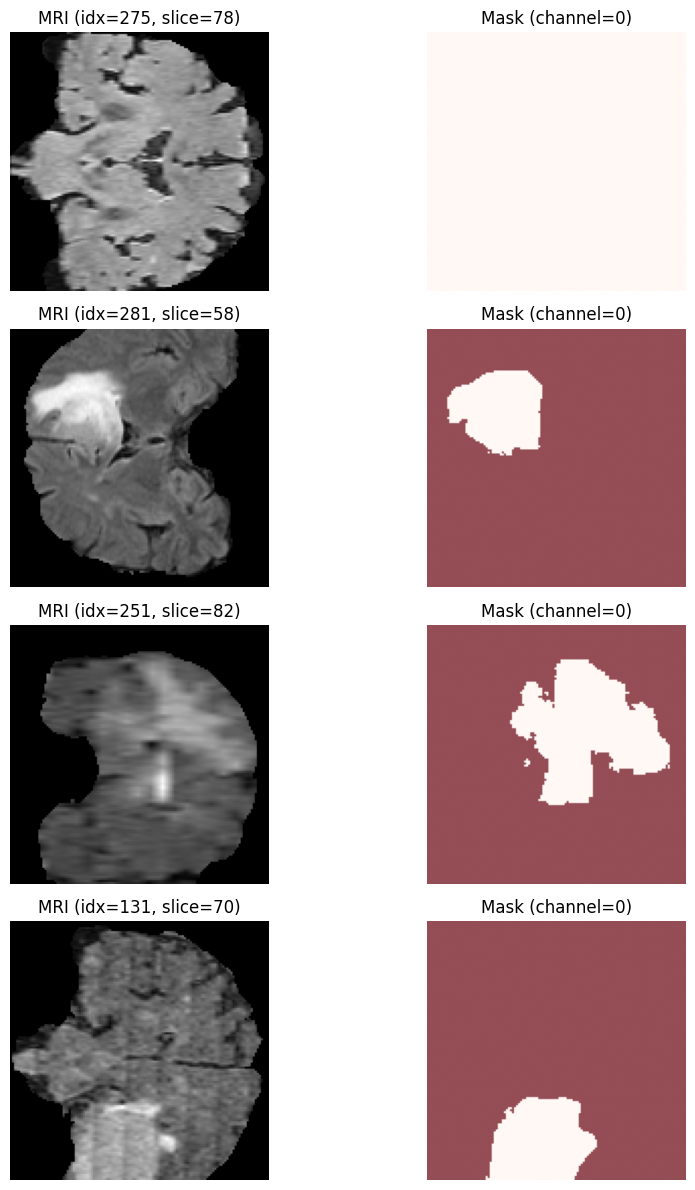

In [5]:
import matplotlib.pyplot as plt
import random

def show_multiple_random_samples(train_ds, mask_channel=1, num_samples=4):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 3 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(train_ds) - 1)
        img, msk = train_ds[idx]

        img_np = img[0].numpy()  # FLAIR image (D, H, W)
        msk_np = msk[mask_channel].numpy()  # Mask for given channel

        slice_idx = random.randint(0, img_np.shape[0] - 1)

        axs[i, 0].imshow(img_np[slice_idx], cmap="gray")
        axs[i, 0].set_title(f"MRI (idx={idx}, slice={slice_idx})")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(msk_np[slice_idx], cmap="Reds", alpha=0.7)
        axs[i, 1].set_title(f"Mask (channel={mask_channel})")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# 🔁 Use this to see 4 random samples with FLAIR and tumor mask
show_multiple_random_samples(train_ds, mask_channel=0)

# 3D U-Net Model

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, base_ch=8):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base_ch)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)
        self.bottleneck = ConvBlock(base_ch*8, base_ch*16)

        self.up4 = nn.ConvTranspose3d(base_ch*16, base_ch*8, 2, stride=2)
        self.dec4 = ConvBlock(base_ch*16, base_ch*8)
        self.up3 = nn.ConvTranspose3d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = ConvBlock(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose3d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose3d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = ConvBlock(base_ch*2, base_ch)

        self.out_conv = nn.Conv3d(base_ch, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool3d(e1, 2))
        e3 = self.enc3(F.max_pool3d(e2, 2))
        e4 = self.enc4(F.max_pool3d(e3, 2))
        b = self.bottleneck(F.max_pool3d(e4, 2))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final_activation(self.out_conv(d1))

# Dice Loss

In [7]:
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    dsc = dice_loss(pred, target)
    return 0.5 * bce + 0.5 * dsc


In [8]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        """
        Stops training if the validation loss doesn't improve after 'patience' epochs.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [9]:
def log_prediction(writer, model, val_dl, epoch, device):
    model.eval()
    with torch.no_grad():
        # Get one random batch
        val_batch = next(iter(val_dl))
        img, msk = val_batch
        img, msk = img.to(device), msk.to(device)

        pred = model(img)

        # First sample in batch
        img = img[0].cpu().numpy()     # (C, D, H, W)
        msk = msk[0].cpu().numpy()     # (C, D, H, W)
        pred = pred[0].cpu().numpy()   # (C, D, H, W)

        slice_idx = img.shape[1] // 2

        # Normalize MRI slice
        mri_slice = img[0, slice_idx]
        mri_slice = (mri_slice - mri_slice.min()) / (mri_slice.max() - mri_slice.min() + 1e-8)
        mri_rgb = np.stack([mri_slice]*3, axis=0)

        panels = [mri_rgb]  # start with MRI

        for ch in range(3):  # for each tumor class
            gt = msk[ch, slice_idx]
            pr = pred[ch, slice_idx]

            gt = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
            pr = (pr - pr.min()) / (pr.max() - pr.min() + 1e-8)

            gt_rgb = np.stack([gt]*3, axis=0)
            pr_rgb = np.stack([pr]*3, axis=0)

            panels.extend([gt_rgb, pr_rgb])

        # Concatenate horizontally: [3, H, W_total]
        concat = np.concatenate(panels, axis=2)

        writer.add_image("MRI_GT_Pred_All_Classes", concat, global_step=epoch)


In [10]:
def log_predictions_across_epochs(writer, model, val_ds, fixed_indices, epoch, device):
    model.eval()
    with torch.no_grad():
        for idx in fixed_indices:
            img, msk = val_ds[idx]
            img = img.unsqueeze(0).to(device)  # Add batch dimension
            msk = msk.numpy()

            pred = model(img).squeeze(0).cpu().numpy()
            img = img.squeeze(0).cpu().numpy()

            slice_idx = img.shape[1] // 2  # middle depth slice
            mri_slice = img[0, slice_idx]
            mri_slice = (mri_slice - mri_slice.min()) / (mri_slice.max() - mri_slice.min() + 1e-8)
            mri_rgb = np.stack([mri_slice]*3, axis=0)

            panels = [mri_rgb]
            for ch in range(3):
                gt = msk[ch, slice_idx]
                pr = pred[ch, slice_idx]

                gt = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
                pr = (pr - pr.min()) / (pr.max() - pr.min() + 1e-8)

                gt_rgb = np.stack([gt]*3, axis=0)
                pr_rgb = np.stack([pr]*3, axis=0)

                panels.extend([gt_rgb, pr_rgb])

            concat = np.concatenate(panels, axis=2)

            tag = f"Case_{idx}_Epoch_{epoch+1}"
            # writer.add_image(tag, concat, global_step=epoch)
            writer.add_image("MRI_GT_Pred_All_Classes", concat, global_step=epoch)


In [11]:
def compute_dice_score(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()


In [12]:
def compute_per_class_dice(pred, target, smooth=1e-5):
    C = pred.shape[1]  # number of classes
    scores = []
    for c in range(C):
        p = pred[:, c]
        t = target[:, c]
        intersection = (p * t).sum(dim=(1, 2, 3))
        union = p.sum(dim=(1, 2, 3)) + t.sum(dim=(1, 2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        scores.append(dice.mean().item())
    return scores


# Training Loop

In [13]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# print(f"Using device: {device}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
fixed_val_examples = random.sample(range(len(val_ds)), 5)
train_loss_log = []
val_loss_log = []

best_val_loss = float('inf')
best_model_path = "best_3d_unet_model.pth"
early_stopper = EarlyStopping(patience=30, min_delta=0.0005)


# model = UNet3D(in_channels=1, out_channels=3, base_ch=8).to(device)
model = UNet3D(in_channels=1, out_channels=3, base_ch=32)
model = nn.DataParallel(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

writer = SummaryWriter(log_dir=f"runs/3d_unet_{datetime.now().strftime('%Y%m%d-%H%M%S')}")
num_epochs = 1000
epoch = 0

while epoch < num_epochs:
    start_time = time.time()
    model.train()
    running_loss = 0.0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (img, msk) in enumerate(train_dl):
        img, msk = img.to(device), msk.to(device)

        pred = model(img)
        # loss = dice_loss(pred, msk)
        loss = combined_loss(pred, msk)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 🔄 Print status every few batches (or every batch if you want)
        if (batch_idx + 1) % 1 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_dl)} - Loss: {loss.item():.4f}")
            # Flush immediately
            import sys
            sys.stdout.flush()

    avg_loss = running_loss / len(train_dl)
    writer.add_scalar("Loss/train", avg_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0.0
    dice_score_epoch = 0.0
    with torch.no_grad():
        for img, msk in val_dl:
            img, msk = img.to(device), msk.to(device)
            pred = model(img)
            val_loss += dice_loss(pred, msk).item()
            dice_score_epoch += compute_dice_score(pred, msk)

            per_class_scores = compute_per_class_dice(pred, msk)
            for i, score in enumerate(per_class_scores):
                writer.add_scalar(f"Dice_class_{i}/val", score, epoch)
            

    avg_val_loss = val_loss / len(val_dl)
    avg_dice_score = dice_score_epoch / len(val_dl)
    writer.add_scalar("Loss/val", avg_val_loss, epoch)
    writer.add_scalar("Dice/val", avg_dice_score, epoch)
    print(f"Epoch {epoch+1} Completed ✅ | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    train_loss_log.append({"epoch": epoch + 1, "loss": avg_loss})
    val_loss_log.append({"epoch": epoch + 1, "loss": avg_val_loss})

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model at epoch {epoch+1} with val_loss {avg_val_loss:.4f}")

    # Early stopping
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"🛑 Early stopping at epoch {epoch+1}")
        break
    
    # log_prediction(writer, model, val_dl, epoch, device)
    log_predictions_across_epochs(writer, model, val_ds, fixed_val_examples, epoch, device)
    epoch_time = time.time() - start_time
    writer.add_scalar("Time/epoch_duration_sec", epoch_time, epoch)
    epoch += 1

torch.save(model.state_dict(), "3d_unet_decathlon.pth")
pd.DataFrame(train_loss_log).to_csv("train_loss.csv", index=False)
pd.DataFrame(val_loss_log).to_csv("val_loss.csv", index=False)


Epoch 1/1000
  Batch 1/25 - Loss: 0.6845
  Batch 2/25 - Loss: 0.6504
  Batch 3/25 - Loss: 0.6244
  Batch 4/25 - Loss: 0.6143
  Batch 5/25 - Loss: 0.6044
  Batch 6/25 - Loss: 0.5992
  Batch 7/25 - Loss: 0.5965
  Batch 8/25 - Loss: 0.5992
  Batch 9/25 - Loss: 0.5906
  Batch 10/25 - Loss: 0.5771
  Batch 11/25 - Loss: 0.5868
  Batch 12/25 - Loss: 0.5800
  Batch 13/25 - Loss: 0.5796
  Batch 14/25 - Loss: 0.5719
  Batch 15/25 - Loss: 0.5721
  Batch 16/25 - Loss: 0.5691
  Batch 17/25 - Loss: 0.5676
  Batch 18/25 - Loss: 0.5606
  Batch 19/25 - Loss: 0.5596
  Batch 20/25 - Loss: 0.5596
  Batch 21/25 - Loss: 0.5617
  Batch 22/25 - Loss: 0.5543
  Batch 23/25 - Loss: 0.5525
  Batch 24/25 - Loss: 0.5578
  Batch 25/25 - Loss: 0.5377
Epoch 1 Completed ✅ | Train Loss: 0.5845 | Val Loss: 0.6952
✅ Saved best model at epoch 1 with val_loss 0.6952

Epoch 2/1000
  Batch 1/25 - Loss: 0.5459
  Batch 2/25 - Loss: 0.5416
  Batch 3/25 - Loss: 0.5408
  Batch 4/25 - Loss: 0.5333
  Batch 5/25 - Loss: 0.5350
  Bat

# Plotting the loss function
- Download the training loss and Val loss using tensorboard

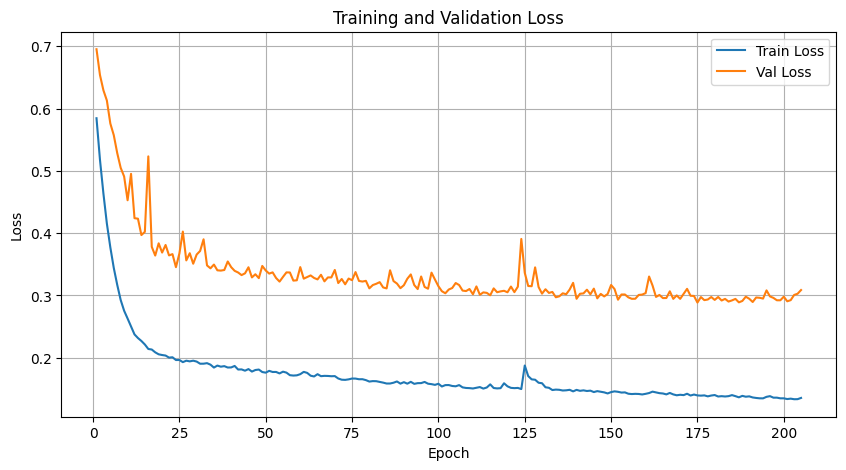

In [15]:
train_loss = pd.read_csv("train_loss.csv")
val_loss = pd.read_csv("val_loss.csv")

plt.figure(figsize=(10, 5))
plt.plot(train_loss['epoch'], train_loss['loss'], label='Train Loss')
plt.plot(val_loss['epoch'], val_loss['loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

In [16]:
model.eval()
test_dice = 0
with torch.no_grad():
    for img, msk in test_dl:
        img, msk = img.to(device), msk.to(device)
        pred = model(img)
        test_dice += 1 - dice_loss(pred, msk).item()

print(f"Average Dice Coefficient on test dataset = {test_dice / len(test_dl):.4f}")


Average Dice Coefficient on test dataset = 0.7152
